In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = (30, 10)
pd.options.mode.chained_assignment = None  # default='warn'

Leemos el fichero de disco, obtenido mediante una API interna del sistema de monitorización.

In [2]:
df = pd.read_csv('/home/mhuertas/.cache/webreport/following_error_2021_03/merge_samples.gz',dtype={"OE.ObservingEngine.currentObservingState": "string"})

Existen muchos valores NaN ya que no todos los monitores se samplean a la misma frecuencia, por lo que para un mismo instante no tenemos valores para todos los monitores. Tambien cambiamos el orden de las columnas.

In [3]:
df = df.fillna(method='ffill')
df = df.dropna()

column_names=['TimeStampLong',\
              'MACS.AzimuthAxis.position',\
              'MACS.AzimuthAxis.followingError',\
              'MACS.ElevationAxis.position',\
              'OE.ObservingEngine.currentObservingState',\
              'OE.ObservingEngine.slowGuideErrorA',\
              'OE.ObservingEngine.slowGuideErrorB',\
              'ECS.DomeRotation.actualPosition',\
              'ECS.UpperShutter.actualPosition',\
              'EMCS.WeatherStation.meanWindSpeed',\
              'EMCS.WeatherStation.windDirection'
              ]
df = df.reindex(columns=column_names)

Convertios el following error de radians to arc/sec. Un valor de 0.1 arc/sec en 1 px en detector, lo que significa que un following error < 0.1 no es significativo de problemas. Por otro lado, con el following error es necesario normalizarlo con el coseno de la elevación. Realmente es con el coseno de la declinación (TODo incluir declinación).

In [4]:
def normalize_following_error(following_error):
    return following_error * 3600

df['MACS.AzimuthAxis.followingError'] = df.apply(
    lambda row: normalize_following_error(row['MACS.AzimuthAxis.followingError']),
    axis=1)

Filtramos valores por rangos válidos, para eliminar espúreos en mediciones:

MACS.AzimuthAxis.position [0,360] degrees
MACS.ElevationAxis.position [0,90] degrees
ECS.DomeRotation.actualPosition [0,360] degrees
ECS.UpperShutter.actualPosition [0,90] degrees
EMCS.WeatherStation.windDirection [0,360] degrees
EMCS.WeatherStation.meanWindSpeed [0,100] m/s

TODO check following error correct ranges
Vamos a limitir el estudio (TBC) a valores de following error entre [-10,10] En following de 10 son 100 px en detector, valores mayores pueden ser espureos.

In [5]:
df = df[ (df['MACS.AzimuthAxis.position'] >= -180 ) & ( df['MACS.AzimuthAxis.position'] <= 360 ) ]
df = df[ (df['MACS.ElevationAxis.position'] >= 0 ) & ( df['MACS.ElevationAxis.position'] <= 90 ) ]
df = df[ (df['ECS.DomeRotation.actualPosition'] >= 0 ) & ( df['ECS.DomeRotation.actualPosition'] <= 360 ) ]
df = df[ (df['ECS.UpperShutter.actualPosition'] >= 0 ) & ( df['ECS.UpperShutter.actualPosition'] <= 90 ) ]
df = df[ (df['EMCS.WeatherStation.windDirection'] >= 0 ) & ( df['EMCS.WeatherStation.windDirection'] <=360 ) ]
df = df[ (df['EMCS.WeatherStation.meanWindSpeed'] >=0 ) & ( df['EMCS.WeatherStation.meanWindSpeed'] <=100 ) ]
df = df[ (df['MACS.AzimuthAxis.followingError'] >=-10 ) & ( df['MACS.AzimuthAxis.followingError'] <=10 ) ]

Normalizamos azimuth en 0 y 360, ya que son posiciones equivalentes, para compar con dirección del viento. p.e.

In [6]:
def normalize_azimuth(angle):
    return angle % 360

df['MACS.AzimuthAxis.position'] = df.apply(
    lambda row: normalize_azimuth(row['MACS.AzimuthAxis.position']),
    axis=1)


Miramos los valores para hacernos una idea general

In [7]:
df.describe()

,MACS.AzimuthAxis.position,MACS.AzimuthAxis.followingError,MACS.ElevationAxis.position,OE.ObservingEngine.slowGuideErrorA,OE.ObservingEngine.slowGuideErrorB,ECS.DomeRotation.actualPosition,ECS.UpperShutter.actualPosition,EMCS.WeatherStation.meanWindSpeed,EMCS.WeatherStation.windDirection
count,1.559380e+06,1.559380e+06,1.559380e+06,1.559380e+06,1.559380e+06,1.559380e+06,1.559380e+06,1.559380e+06,1.559380e+06
mean,1.855463e+02,2.665300e-02,5.259721e+01,-8.200022e-07,-2.754098e-06,1.850508e+02,7.463640e+01,6.511238e+00,1.945122e+02
std,1.209287e+02,2.027127e+00,1.688684e+01,1.191425e-05,2.820674e-05,1.214818e+02,3.109193e+01,3.049948e+00,6.730602e+01
min,8.860737e-03,-9.999999e+00,0.000000e+00,-9.430900e-05,-5.345080e-04,0.000000e+00,0.000000e+00,3.850889e-01,0.000000e+00
25%,7.738099e+01,-5.308110e-02,4.162437e+01,-1.983797e-07,-1.824905e-07,7.284800e+01,8.769270e+01,4.231511e+00,1.540000e+02
50%,1.880013e+02,0.000000e+00,5.479336e+01,0.000000e+00,0.000000e+00,1.870180e+02,8.793780e+01,6.277033e+00,1.740000e+02
75%,3.188388e+02,5.338499e-02,6.320413e+01,1.728829e-07,2.383133e-07,3.194950e+02,8.794900e+01,8.655033e+00,2.340000e+02
max,3.599925e+02,9.999187e+00,8.999769e+01,9.082496e-04,1.698503e-05,3.599990e+02,8.795200e+01,1.520687e+01,3.590000e+02


En el análisis solo nos interesa cuando se estaba observando y con el telescopio siguiendo a objetos, filtramos aquellas condiciones en que no se esta observando no se está siguiendo objeto.

In [45]:
df['OE.ObservingEngine.currentObservingState'].value_counts()/df.shape[0]

GUIDING     0.571796
OFF          0.15712
TRACKING    0.142355
SLEWING     0.128729
Name: OE.ObservingEngine.currentObservingState, dtype: Float64

Para este estudio nos interesa que la cupula esté abirta, y el telescopio en tracking or guiding

In [46]:
df_guiding = df[( df['OE.ObservingEngine.currentObservingState'] =='GUIDING' )  ]
df_off = df[( df['OE.ObservingEngine.currentObservingState'] =='OFF' )  ]
df_track = df[( df['OE.ObservingEngine.currentObservingState'] =='TRACKING' )  ]
df_slewing = df[( df['OE.ObservingEngine.currentObservingState'] =='SLEWING' )  ]


Miramos como se distribuyen los datos de Azimuth, de forma general.

<AxesSubplot:>

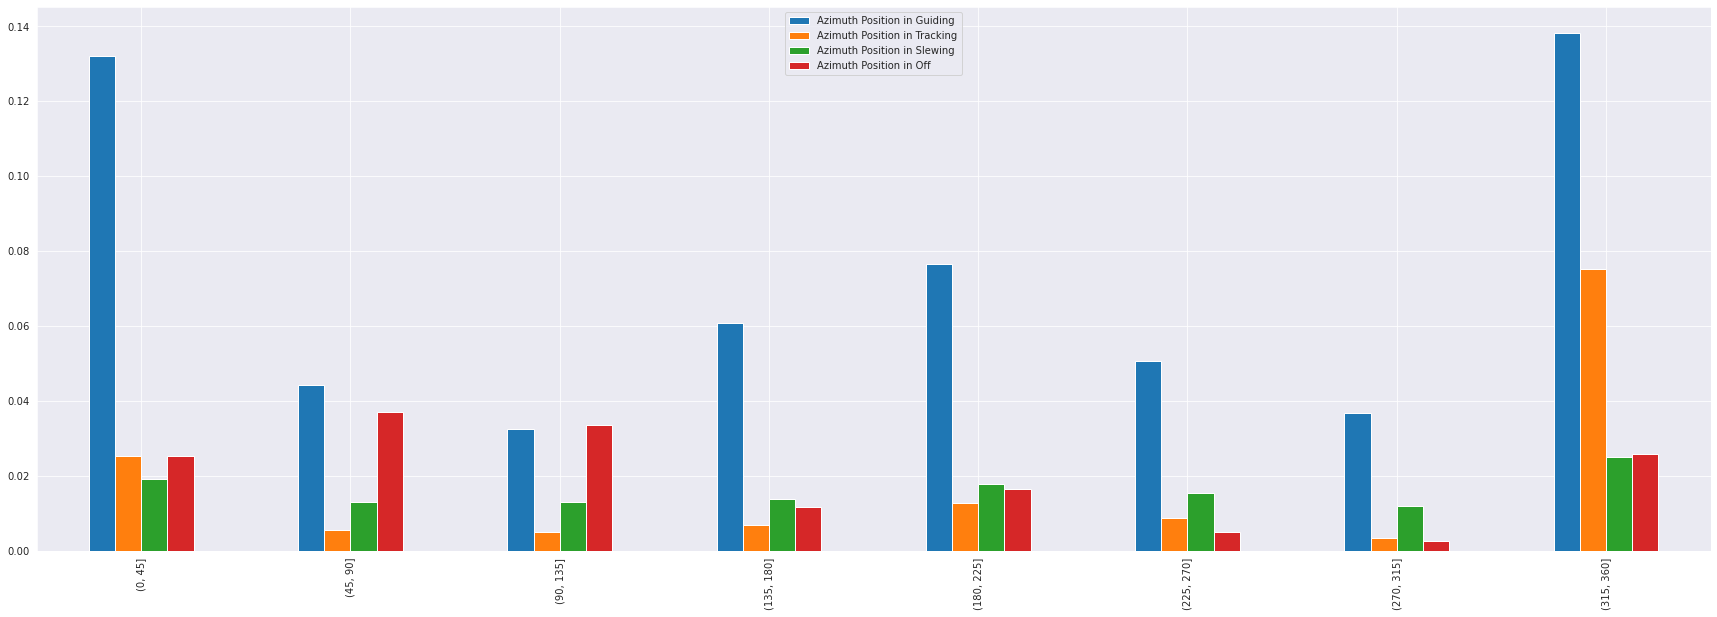

In [53]:
df_azimuth = pd.DataFrame()

df_azimuth['Azimuth Position in Guiding'] = ( pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )
df_azimuth['Azimuth Position in Tracking'] = ( pd.cut(x=df_track['MACS.AzimuthAxis.position'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )
df_azimuth['Azimuth Position in Slewing'] = ( pd.cut(x=df_slewing['MACS.AzimuthAxis.position'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )
df_azimuth['Azimuth Position in Off'] = ( pd.cut(x=df_off['MACS.AzimuthAxis.position'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )


df_azimuth.plot.bar()

Se observa que el Azimuth se distribuye más o menos uniformemente, con un poco de más valores tanto en franja de 0 a 45 grados, como en franja de 315 a 360.

<AxesSubplot:>

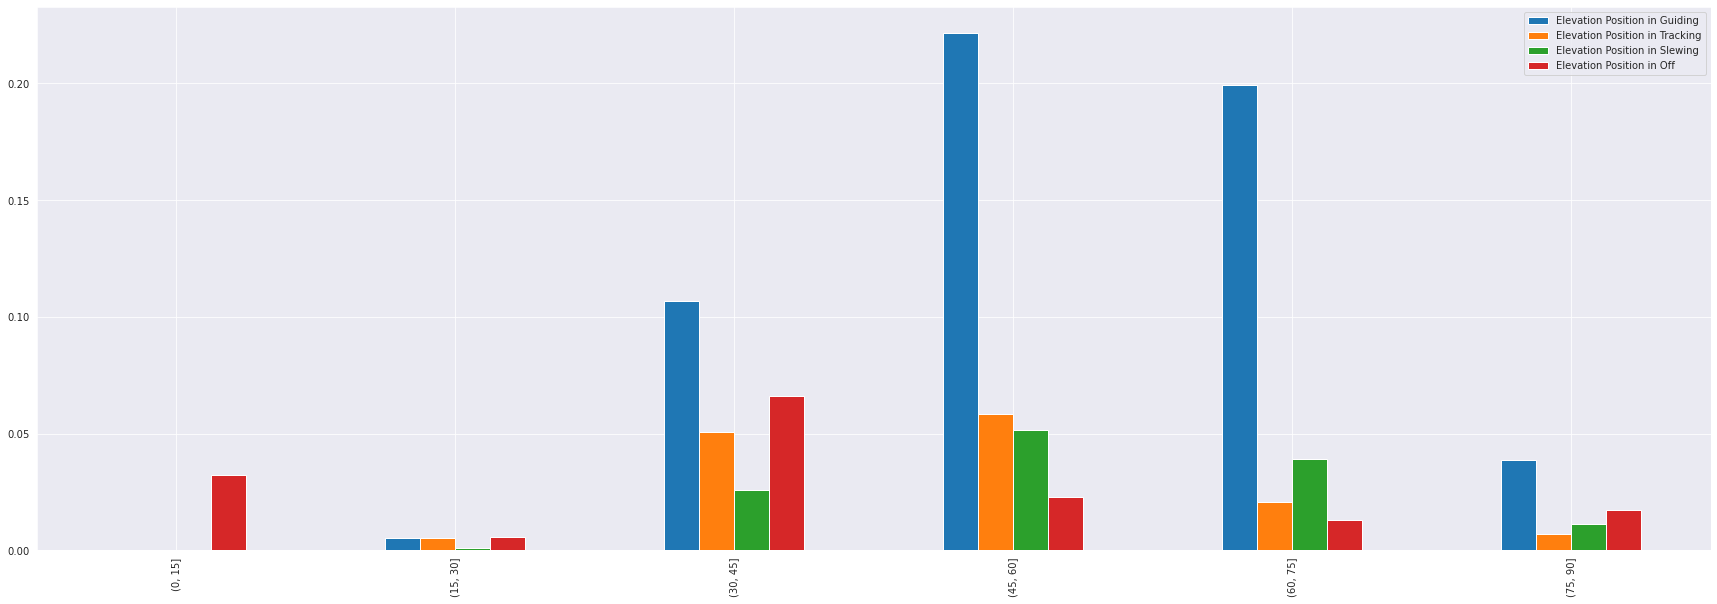

In [57]:
df_elevation = pd.DataFrame()

df_elevation['Elevation Position in Guiding'] = ( pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(0,90+15,15)).value_counts(sort=False) /df.shape[0] )
df_elevation['Elevation Position in Tracking'] = ( pd.cut(x=df_track['MACS.ElevationAxis.position'], bins=np.arange(0,90+15,15)).value_counts(sort=False) /df.shape[0] )
df_elevation['Elevation Position in Slewing'] = ( pd.cut(x=df_slewing['MACS.ElevationAxis.position'], bins=np.arange(0,90+15,15)).value_counts(sort=False) /df.shape[0] )
df_elevation['Elevation Position in Off'] = ( pd.cut(x=df_off['MACS.ElevationAxis.position'], bins=np.arange(0,90+15,15)).value_counts(sort=False) /df.shape[0] )

df_elevation.plot.bar()

Se observa que no tenemos pocos valores para elevación menor de 30. El número mayoritario de datos se concentra entre 40 y 60 grados de elevación, volviendo a disminuir a aptir de los 75 grados.

<AxesSubplot:>

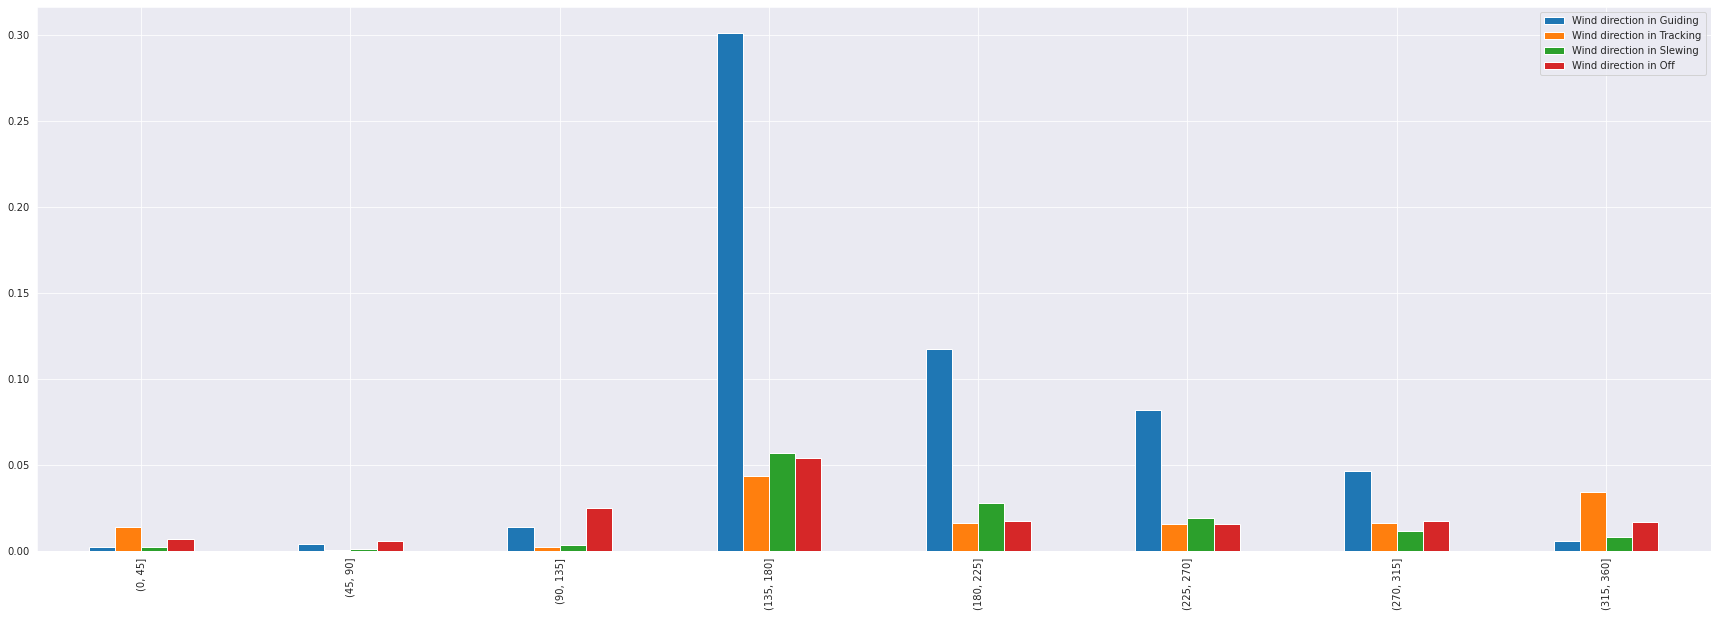

In [59]:
df_wind_dir = pd.DataFrame()

df_wind_dir['Wind direction in Guiding'] = ( pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )
df_wind_dir['Wind direction in Tracking'] = ( pd.cut(x=df_track['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )
df_wind_dir['Wind direction in Slewing'] = ( pd.cut(x=df_slewing['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )
df_wind_dir['Wind direction in Off'] = ( pd.cut(x=df_off['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+45,45)).value_counts(sort=False) /df.shape[0] )

df_wind_dir.plot.bar()

Se observa una clara preferencia por dirección del viento entre 135 y 180, es decir, viento que viene del SUR, SUR-ESTE y SUR-OESTE. Con pocos valores obtenidos con el viento en dirección NORTE, NORT-ESTE.

<AxesSubplot:>

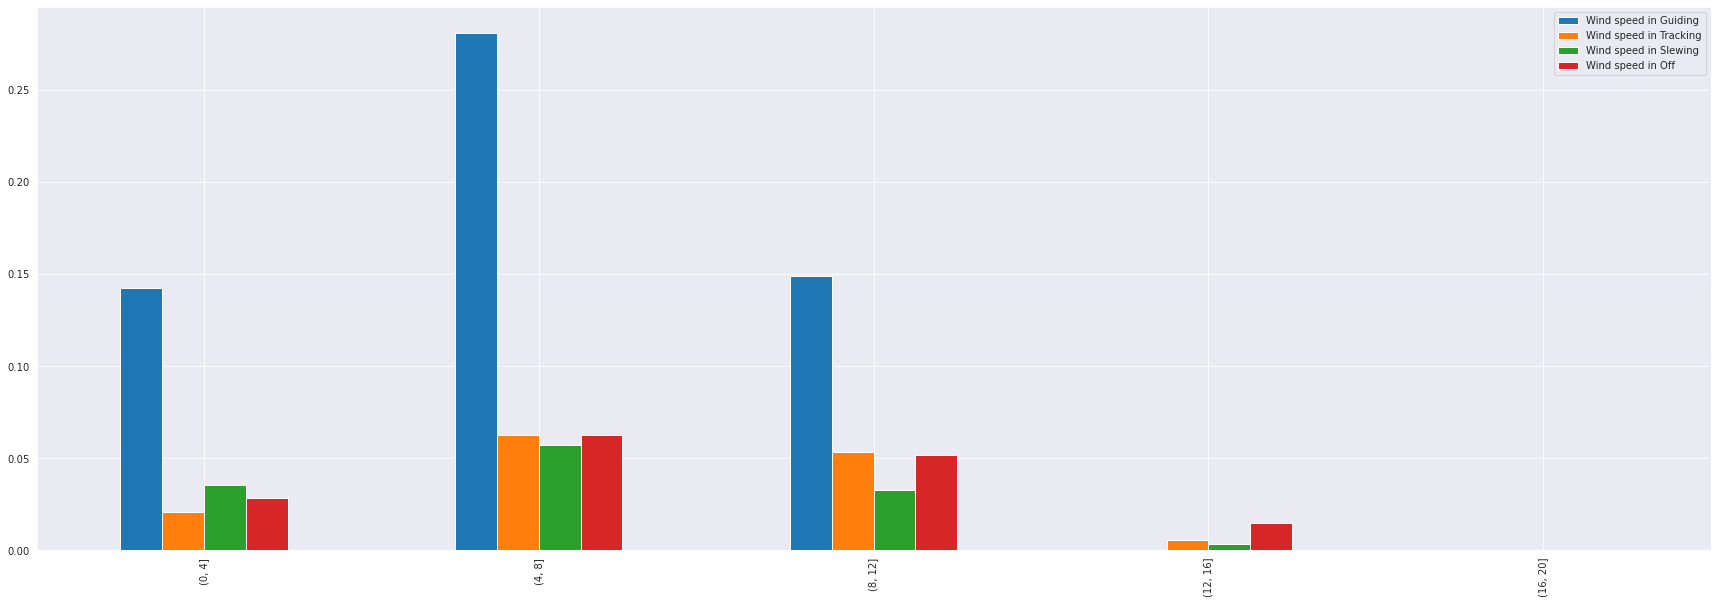

In [61]:
df_wind_speed = pd.DataFrame()

df_wind_speed['Wind speed in Guiding'] = ( pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,20+4,4)).value_counts(sort=False) /df.shape[0] )
df_wind_speed['Wind speed in Tracking'] = ( pd.cut(x=df_track['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,20+4,4)).value_counts(sort=False) /df.shape[0] )
df_wind_speed['Wind speed in Slewing'] = ( pd.cut(x=df_slewing['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,20+4,4)).value_counts(sort=False) /df.shape[0] )
df_wind_speed['Wind speed in Off'] = ( pd.cut(x=df_off['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,20+4,4)).value_counts(sort=False) /df.shape[0] )

df_wind_speed.plot.bar()

Se observa que gran parte de las observaciones se concentran en velocidad del viento entre 4 y 8 de velocidad m/s. Y se observa que a partir de los 12 m/s ya no tenemos observaciones con Guiado, y a partir de 16 m/s no tendríamos observaciones.

<AxesSubplot:>

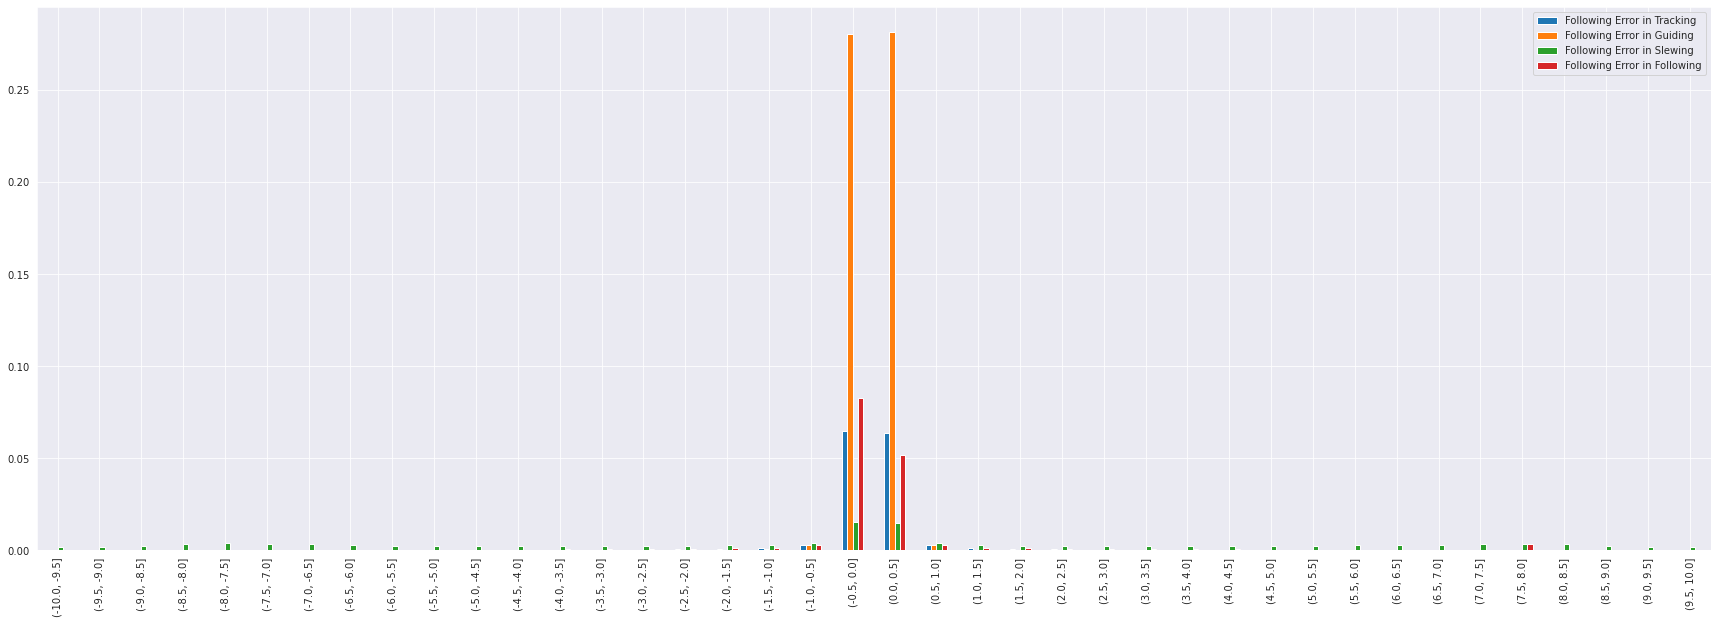

In [62]:
df_following_error = pd.DataFrame()

df_following_error['Following Error in Tracking'] = ( pd.cut(x=df_track['MACS.AzimuthAxis.followingError'], bins=np.arange(-10,10+0.5,0.5)).value_counts(sort=False) /df.shape[0] )
df_following_error['Following Error in Guiding'] = ( pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'], bins=np.arange(-10,10+0.5,0.5)).value_counts(sort=False) /df.shape[0] )
df_following_error['Following Error in Slewing'] = ( pd.cut(x=df_slewing['MACS.AzimuthAxis.followingError'], bins=np.arange(-10,10+0.5,0.5)).value_counts(sort=False) /df.shape[0] )
df_following_error['Following Error in Following'] = ( pd.cut(x=df_off['MACS.AzimuthAxis.followingError'], bins=np.arange(-10,10+0.5,0.5)).value_counts(sort=False) /df.shape[0] )

df_following_error.plot.bar()

Un gran porcentaje (encontrar forma de calcular %) se encuentra entre -1 y 1 de following error.

<AxesSubplot:>

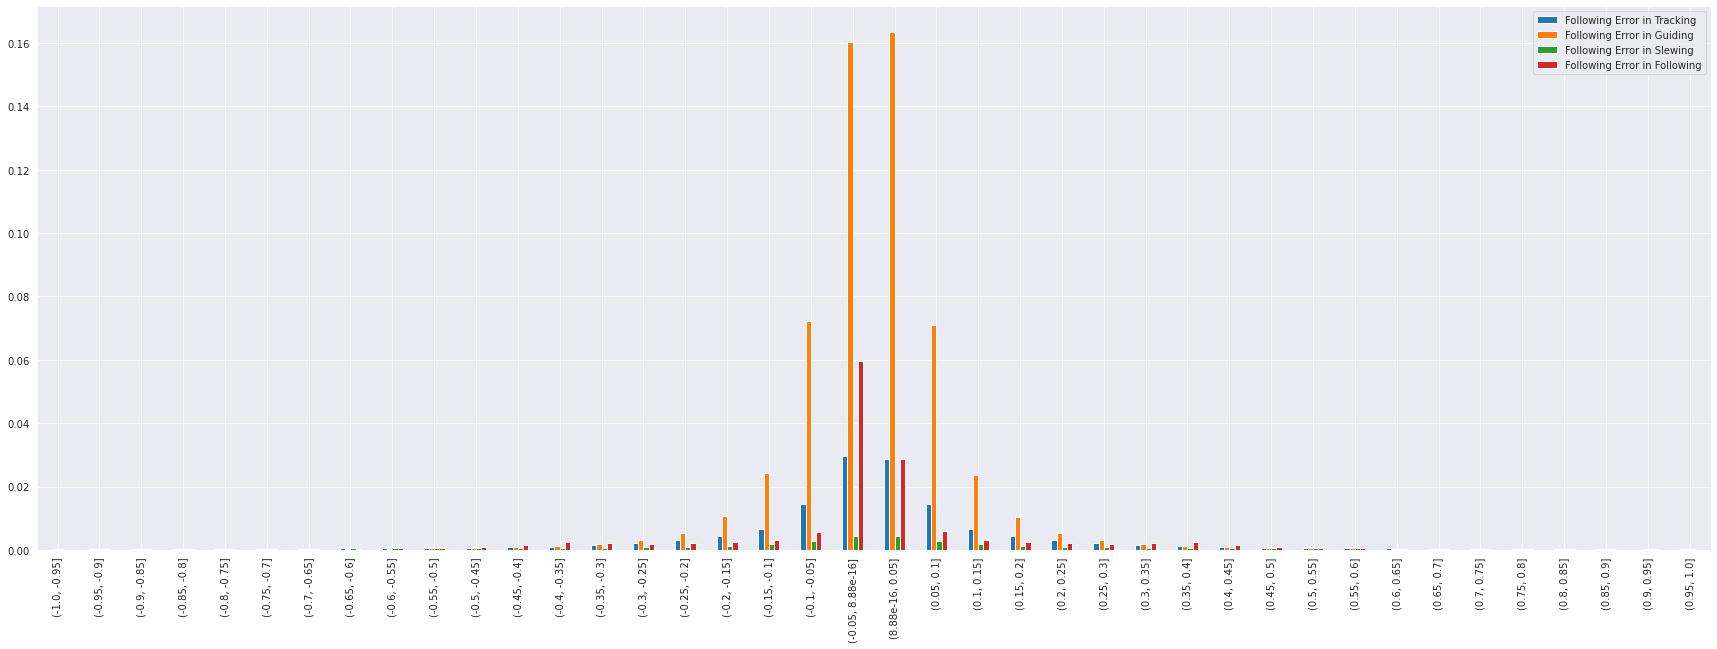

In [63]:
df_following_error_low = pd.DataFrame()

df_following_error_low['Following Error in Tracking'] = ( pd.cut(x=df_track['MACS.AzimuthAxis.followingError'], bins=np.arange(-1,1+0.05,0.05)).value_counts(sort=False) /df.shape[0] )
df_following_error_low['Following Error in Guiding'] = ( pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'], bins=np.arange(-1,1+0.05,0.05)).value_counts(sort=False) /df.shape[0] )
df_following_error_low['Following Error in Slewing'] = ( pd.cut(x=df_slewing['MACS.AzimuthAxis.followingError'], bins=np.arange(-1,1+0.05,0.05)).value_counts(sort=False) /df.shape[0] )
df_following_error_low['Following Error in Following'] = ( pd.cut(x=df_off['MACS.AzimuthAxis.followingError'], bins=np.arange(-1,1+0.05,0.05)).value_counts(sort=False) /df.shape[0] )

df_following_error_low.plot.bar()

Un gran porcentaje (encontrar forma de calcular %) se encuentra entre -0.1 y 0.1 de following error.

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed'>

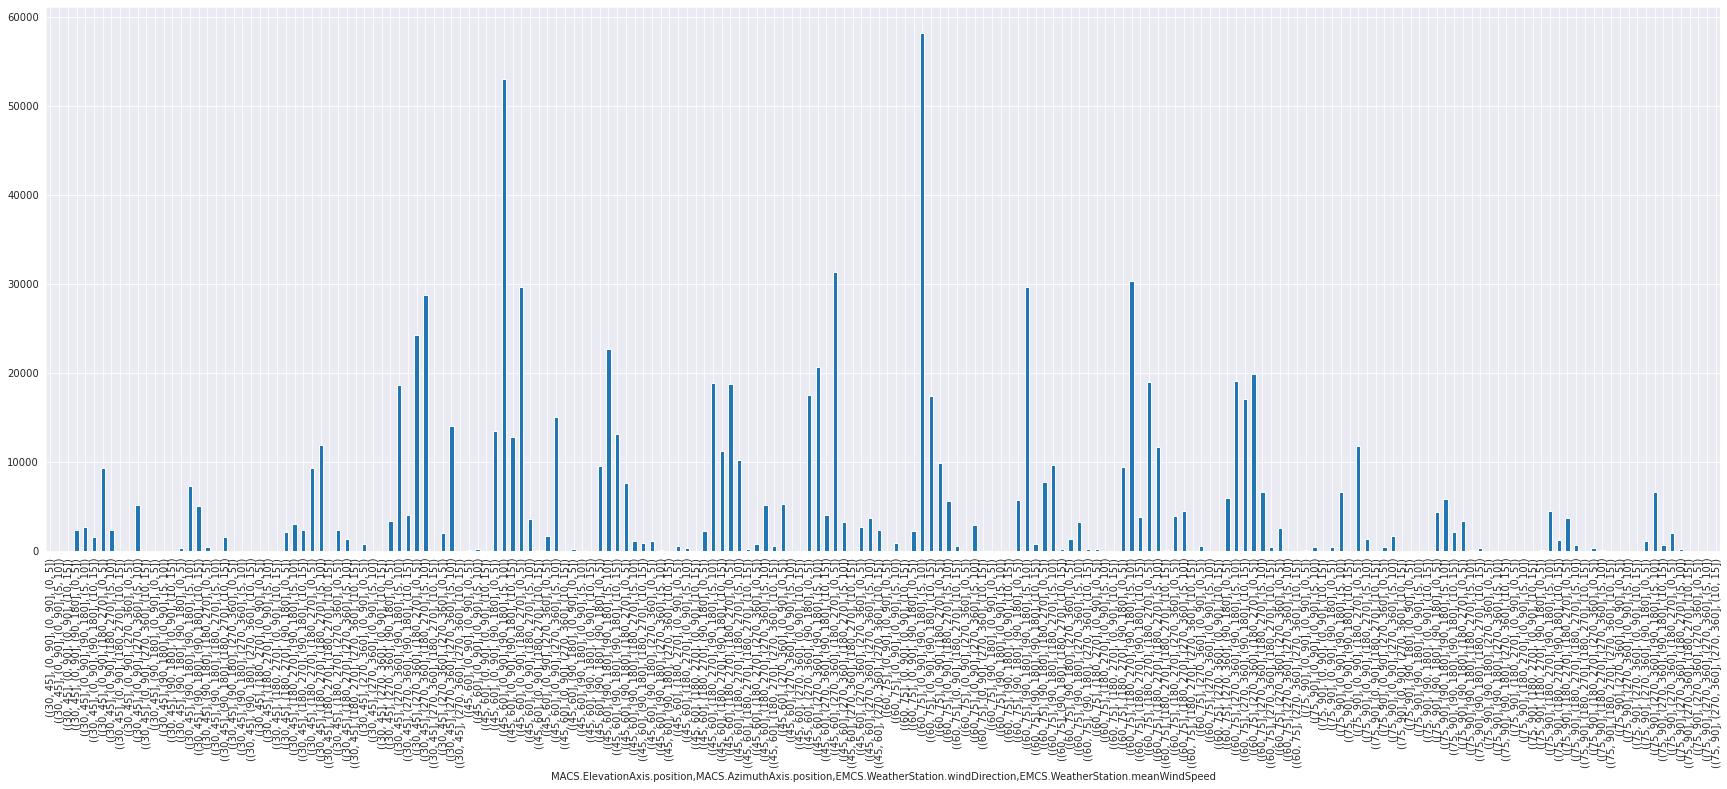

In [64]:
group_var_independent = df_guiding.groupby (
    [
        pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(30,90+15,15)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,15+5,5)),
    ]
)
group_var_independent['MACS.AzimuthAxis.followingError'].count().plot.bar()

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed'>

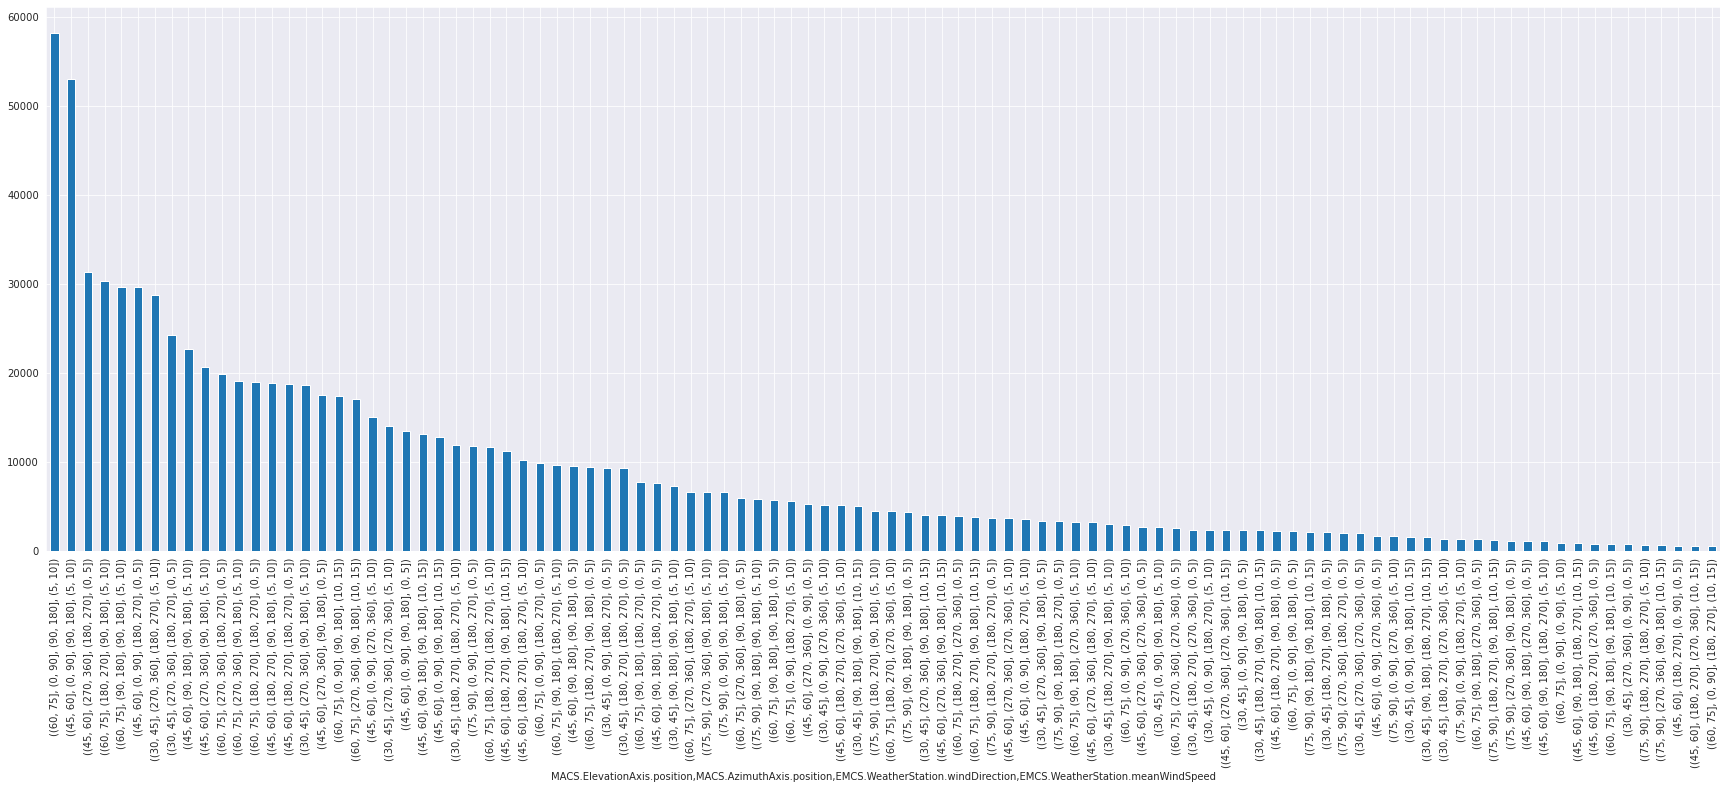

In [70]:
group_var_independent_filter = group_var_independent.count().nlargest(n=100)
group_var_independent_filter.plot.bar()

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed,MACS.AzimuthAxis.followingError'>

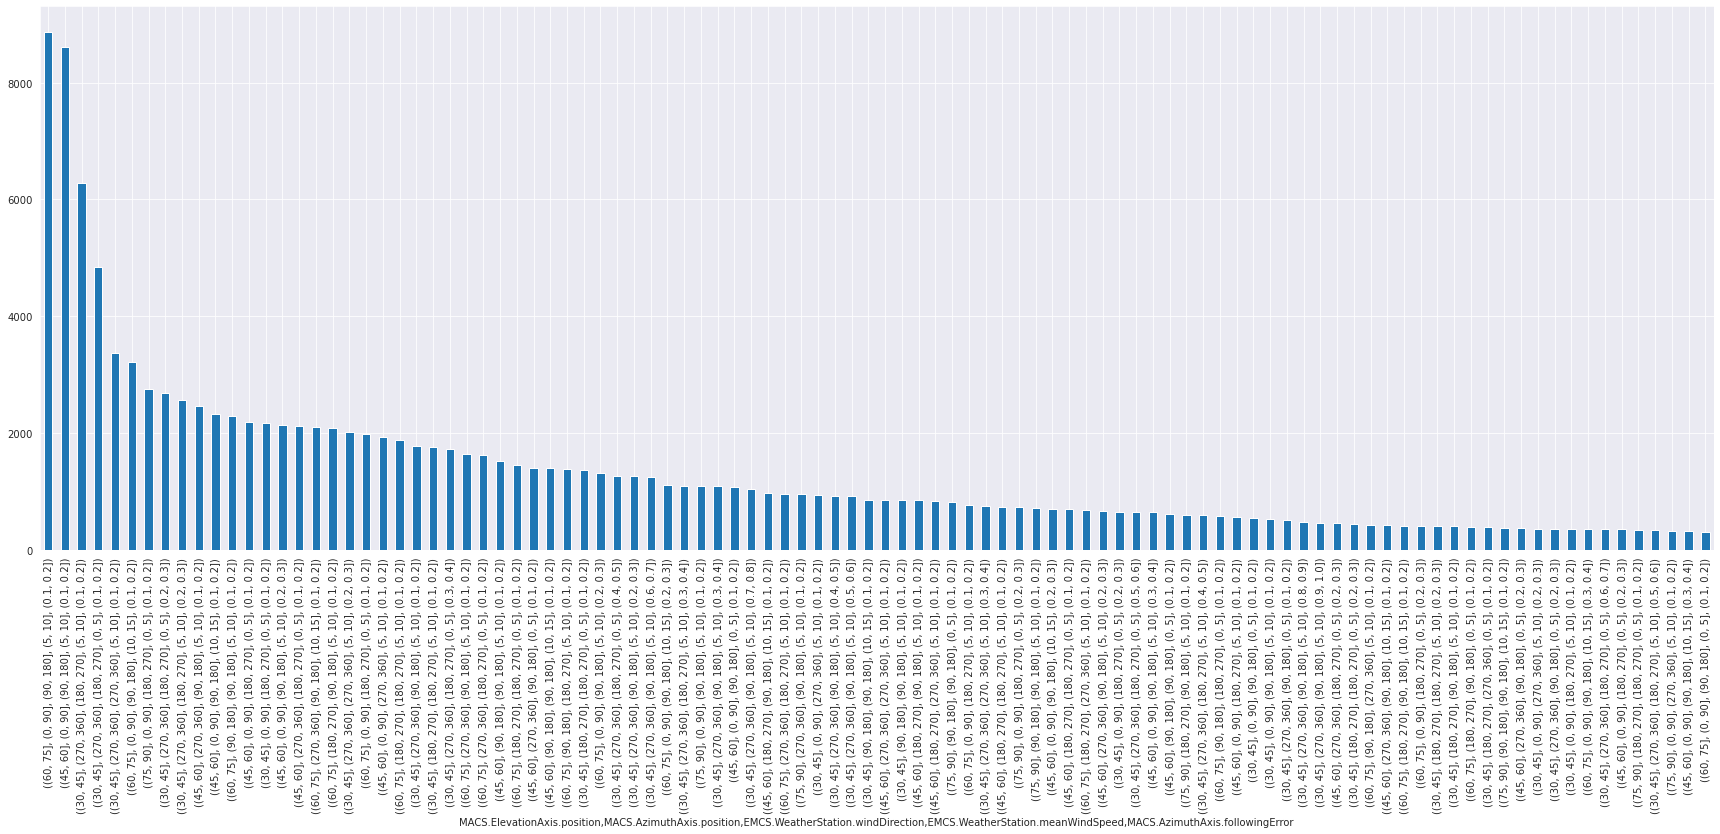

In [79]:
group_var = df_guiding.groupby (
    [
        pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(30,90+15,15)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,15+5,5)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'].abs(), bins=np.arange(0.1,10+0.1,0.1))

    ]
)  ['MACS.AzimuthAxis.followingError']

group_var_filter = group_var.count().nlargest(n=100)
group_var_filter.plot.bar()

<AxesSubplot:>

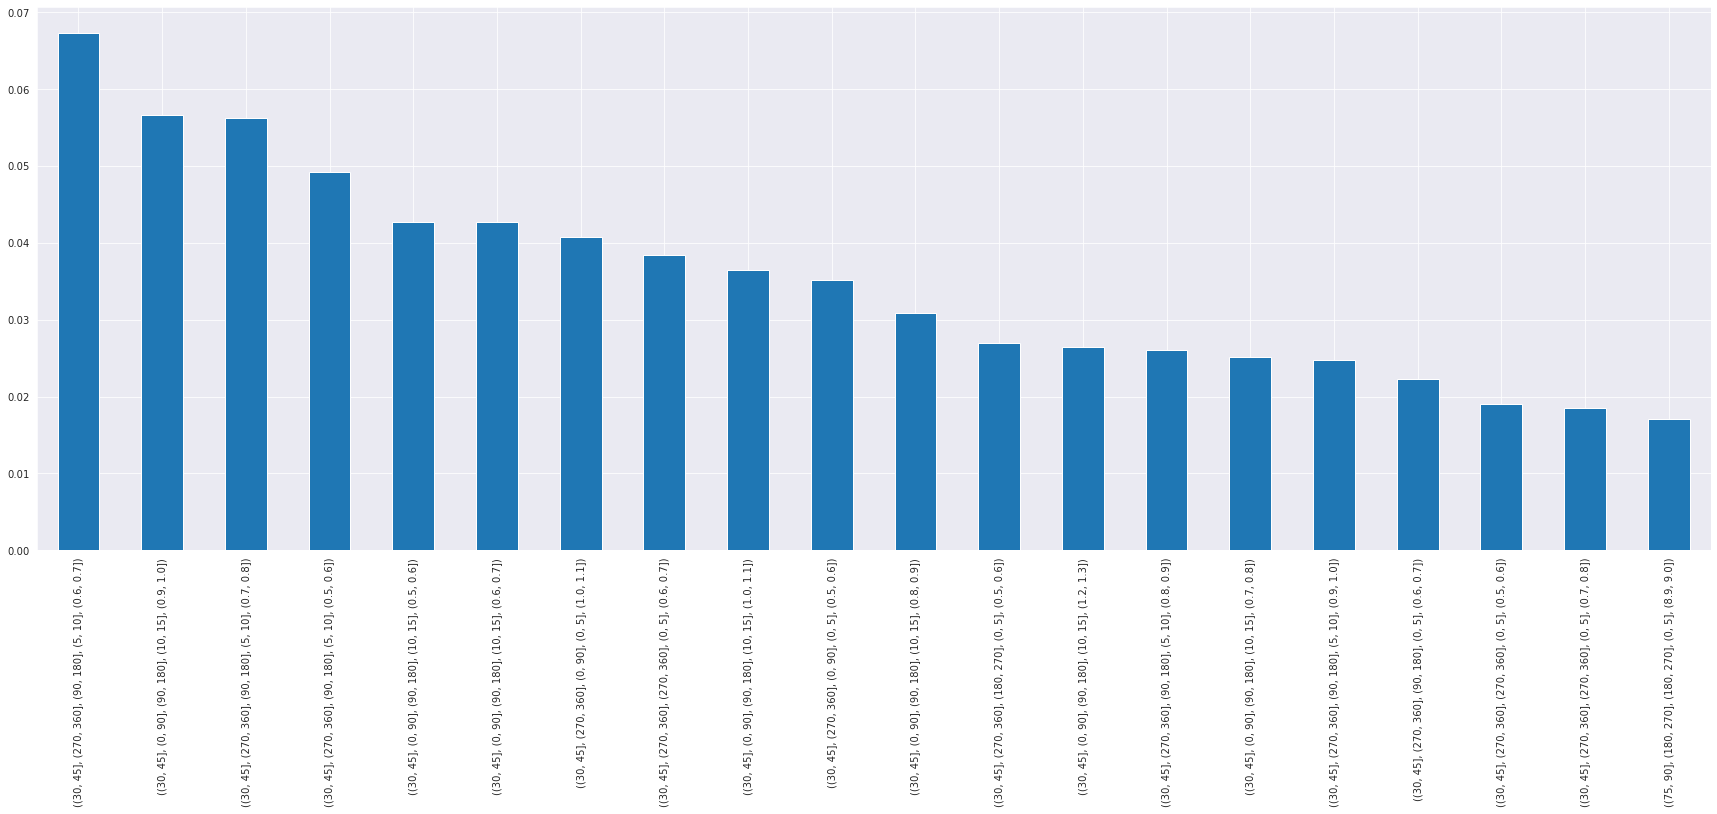

In [94]:
d = {}
group_var_independent_count = group_var_independent.count()
for index, value in group_var_filter.items():
    for i,v in group_var_independent_count.items():
        if i == index[:-1]:
            #print(f"Index : {index}, Value : {value/v}")
            d[index]=value/v

ser = pd.Series(data=d).nlargest(n=20)

ser.plot.bar()

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed,MACS.AzimuthAxis.followingError'>

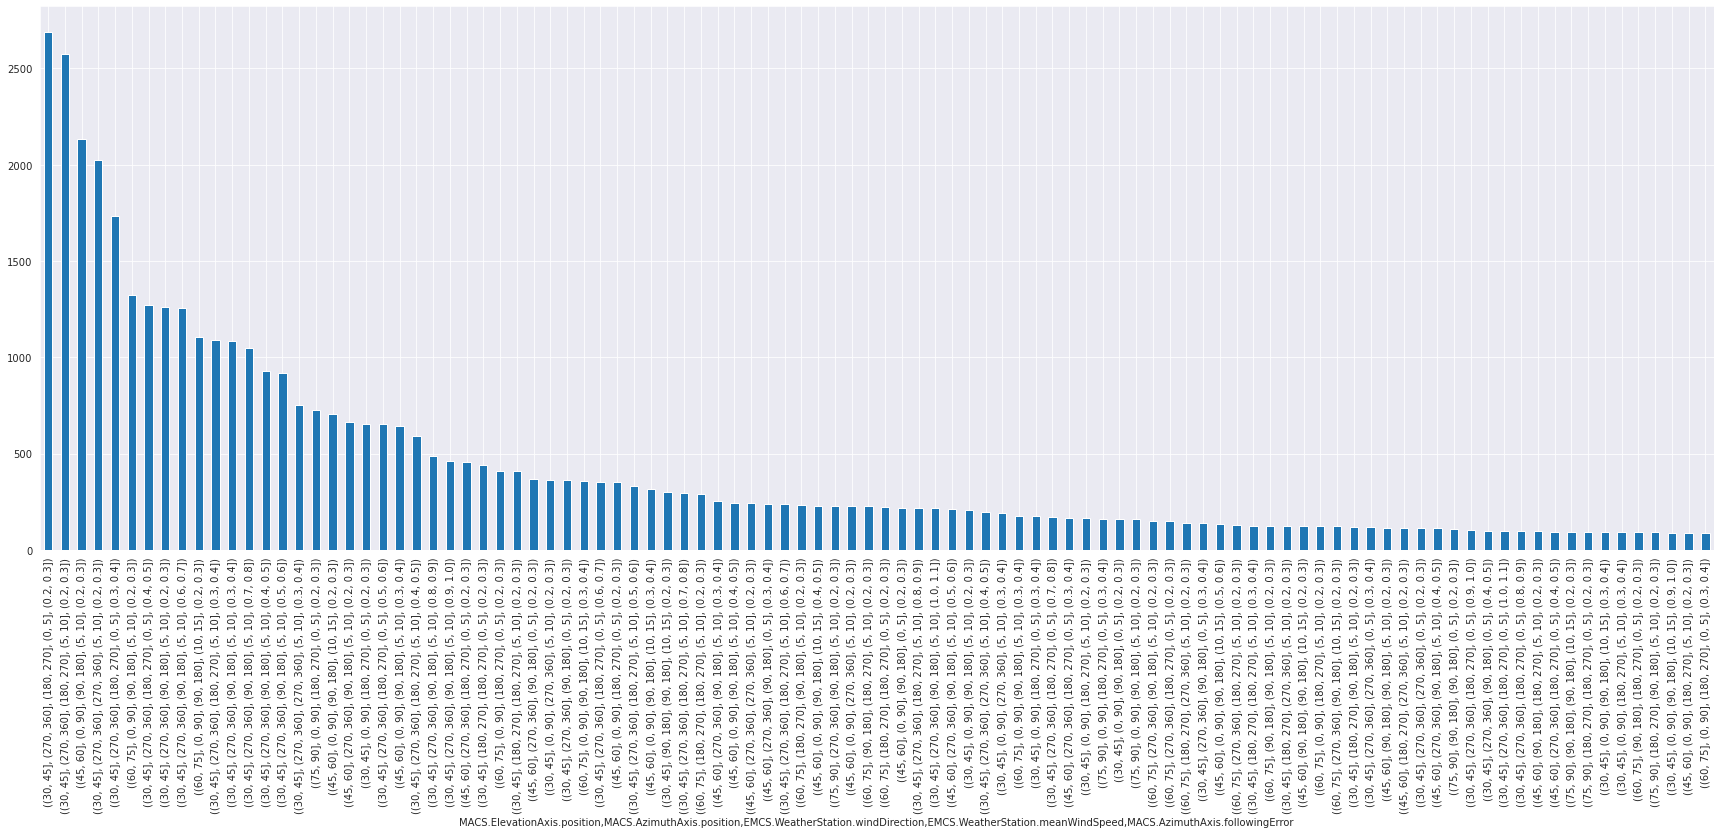

In [82]:
group_var = df_guiding.groupby (
    [
        pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(30,90+15,15)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,15+5,5)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'].abs(), bins=np.arange(0.2,10+0.1,0.1))

    ]
)  ['MACS.AzimuthAxis.followingError']

group_var_filter = group_var.count().nlargest(n=100)
group_var_filter.plot.bar()

<AxesSubplot:>

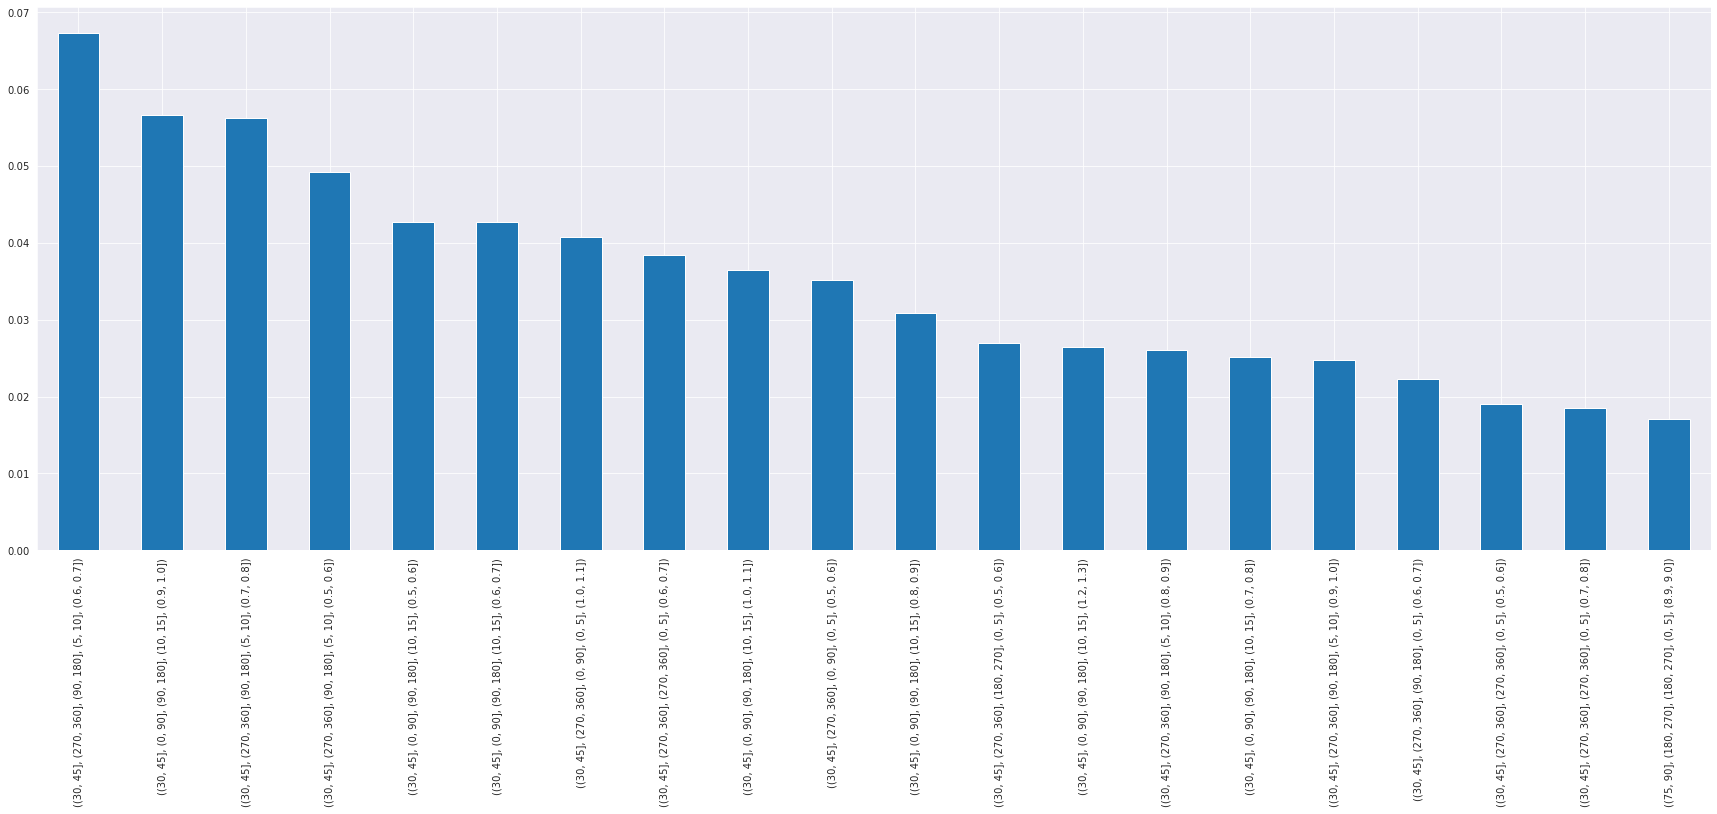

In [93]:
d = {}
group_var_independent_count = group_var_independent.count()
for index, value in group_var_filter.items():
    for i,v in group_var_independent_count.items():
        if i == index[:-1]:
            #print(f"Index : {index}, Value : {value/v}")
            d[index]=value/v

ser = pd.Series(data=d).nlargest(n=20)

ser.plot.bar()

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed,MACS.AzimuthAxis.followingError'>

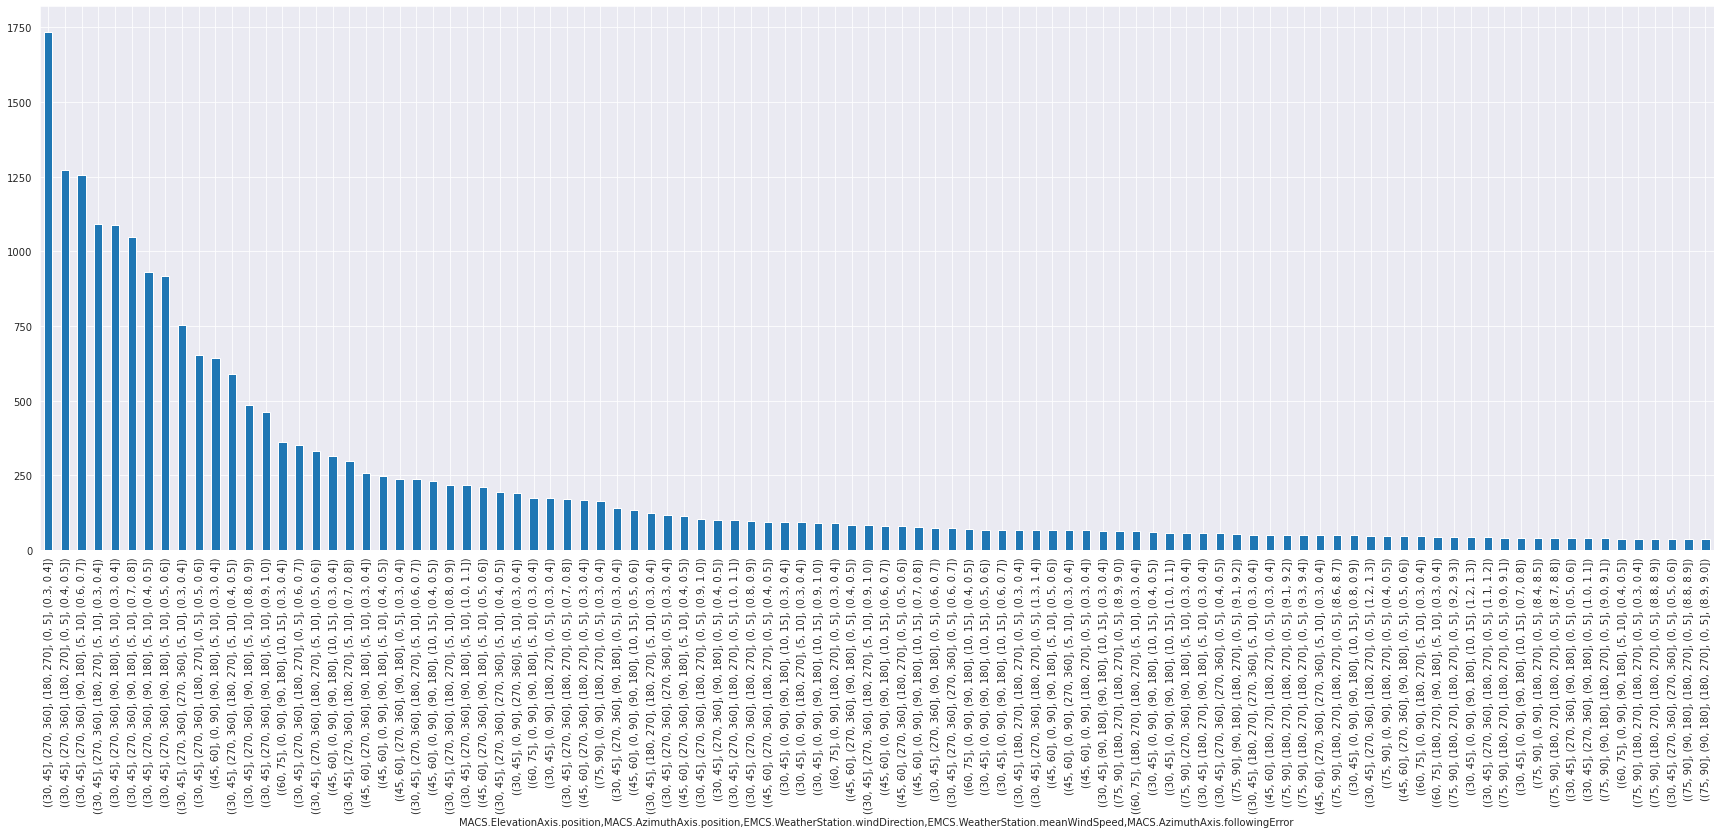

In [84]:
group_var = df_guiding.groupby (
    [
        pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(30,90+15,15)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,15+5,5)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'].abs(), bins=np.arange(0.3,10+0.1,0.1))

    ]
)  ['MACS.AzimuthAxis.followingError']

group_var_filter = group_var.count().nlargest(n=100)
group_var_filter.plot.bar()

<AxesSubplot:>

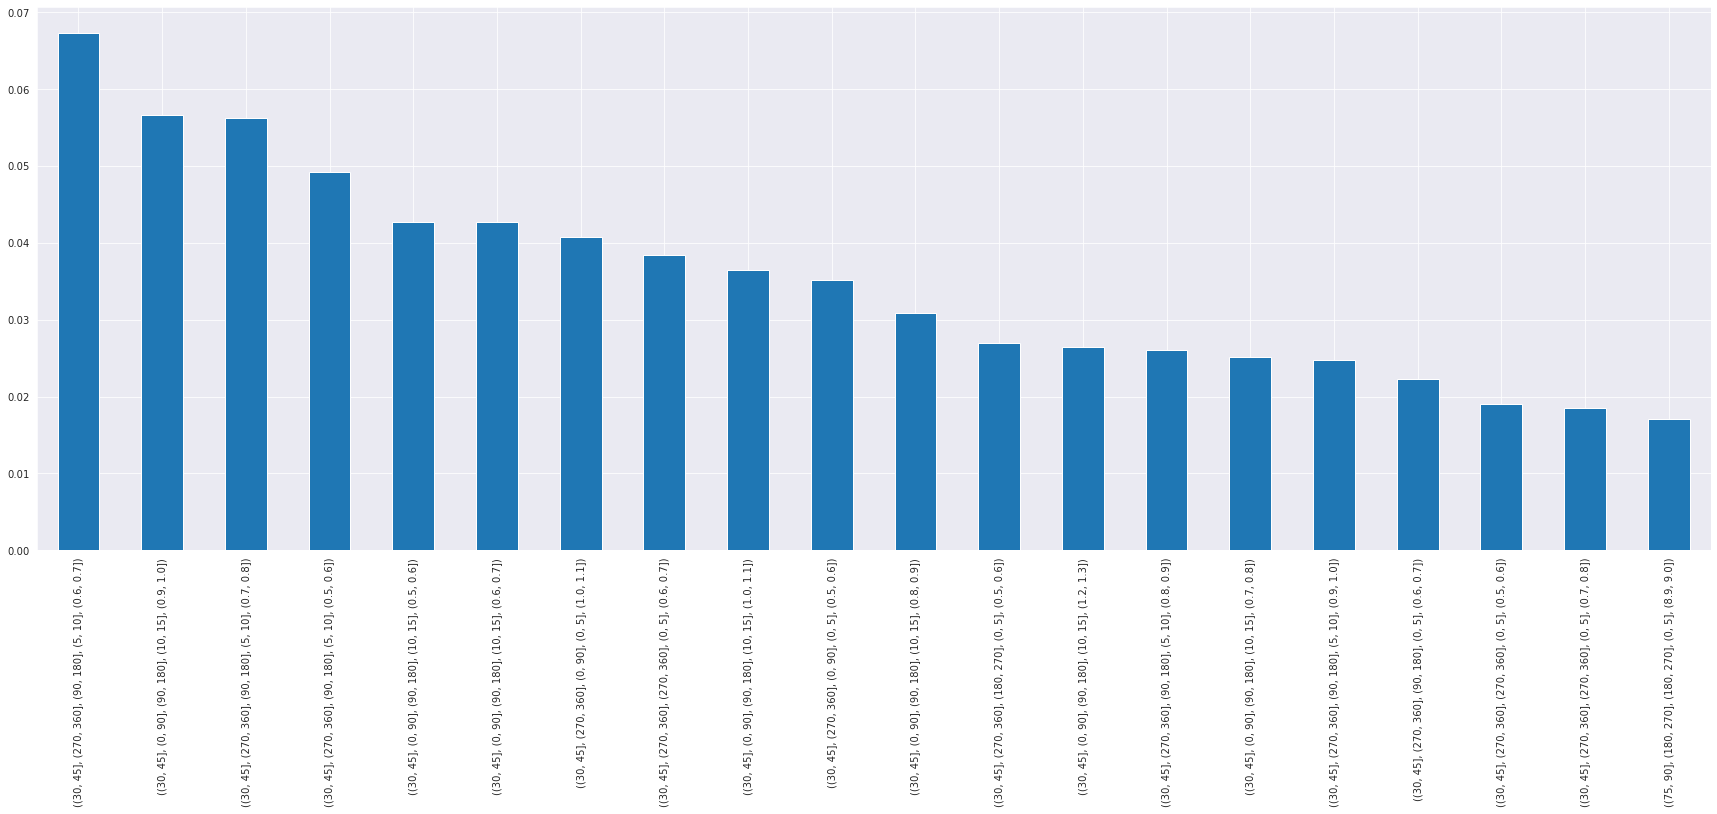

In [92]:
d = {}
group_var_independent_count = group_var_independent.count()
for index, value in group_var_filter.items():
    for i,v in group_var_independent_count.items():
        if i == index[:-1]:
            #print(f"Index : {index}, Value : {value/v}")
            d[index]=value/v

ser = pd.Series(data=d).nlargest(n=20)

ser.plot.bar()

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed,MACS.AzimuthAxis.followingError'>

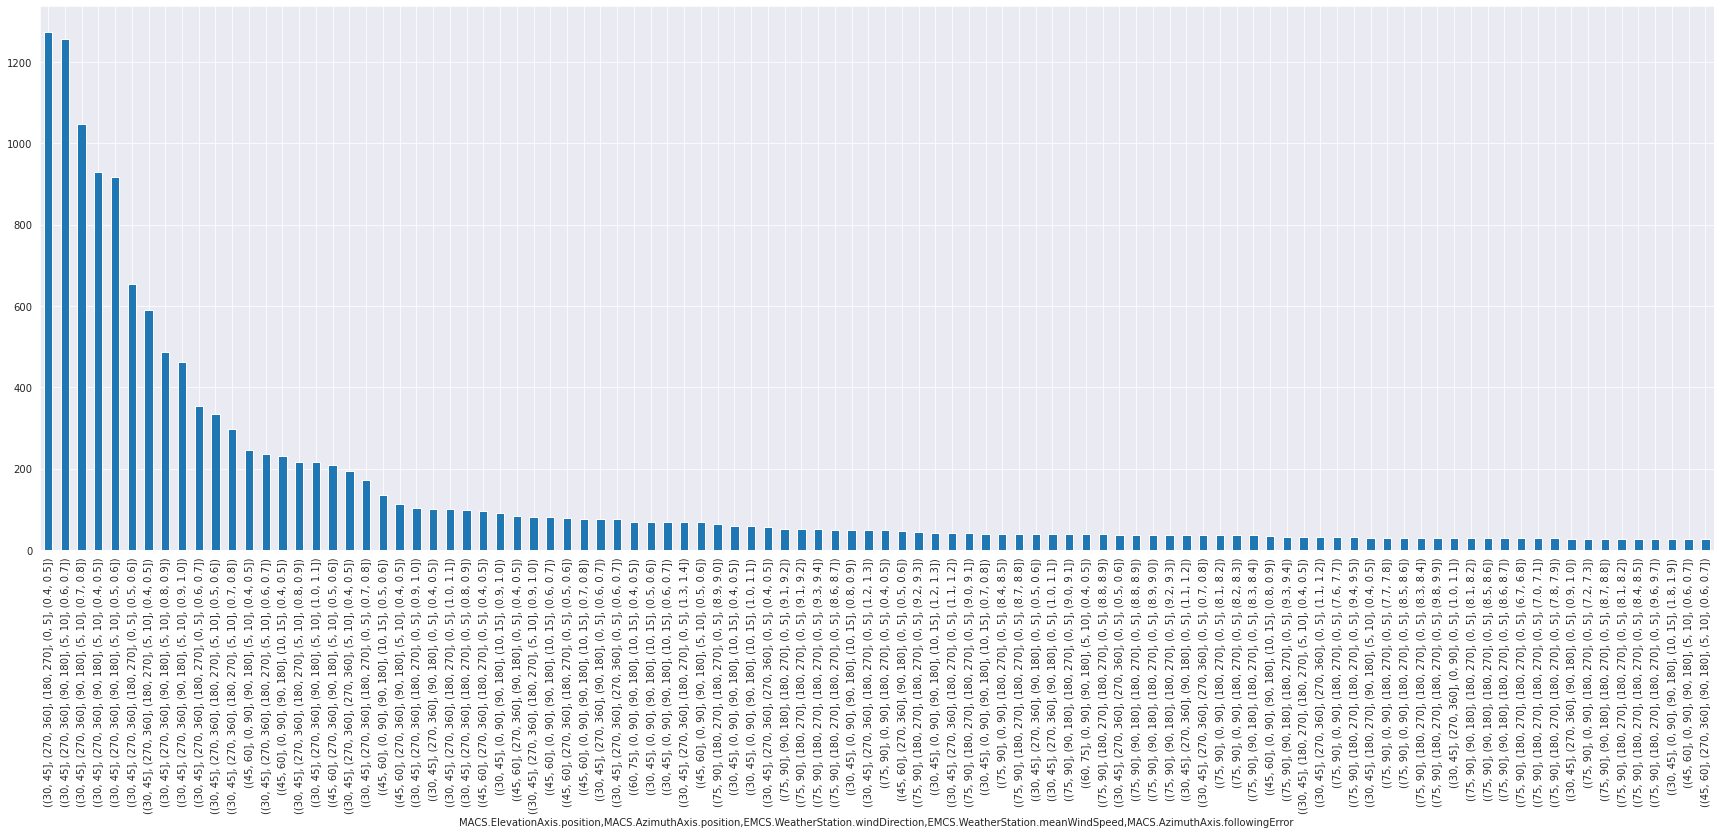

In [86]:
group_var = df_guiding.groupby (
    [
        pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(30,90+15,15)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,15+5,5)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'].abs(), bins=np.arange(0.4,10+0.1,0.1))

    ]
)  ['MACS.AzimuthAxis.followingError']

group_var_filter = group_var.count().nlargest(n=100)
group_var_filter.plot.bar()

<AxesSubplot:>

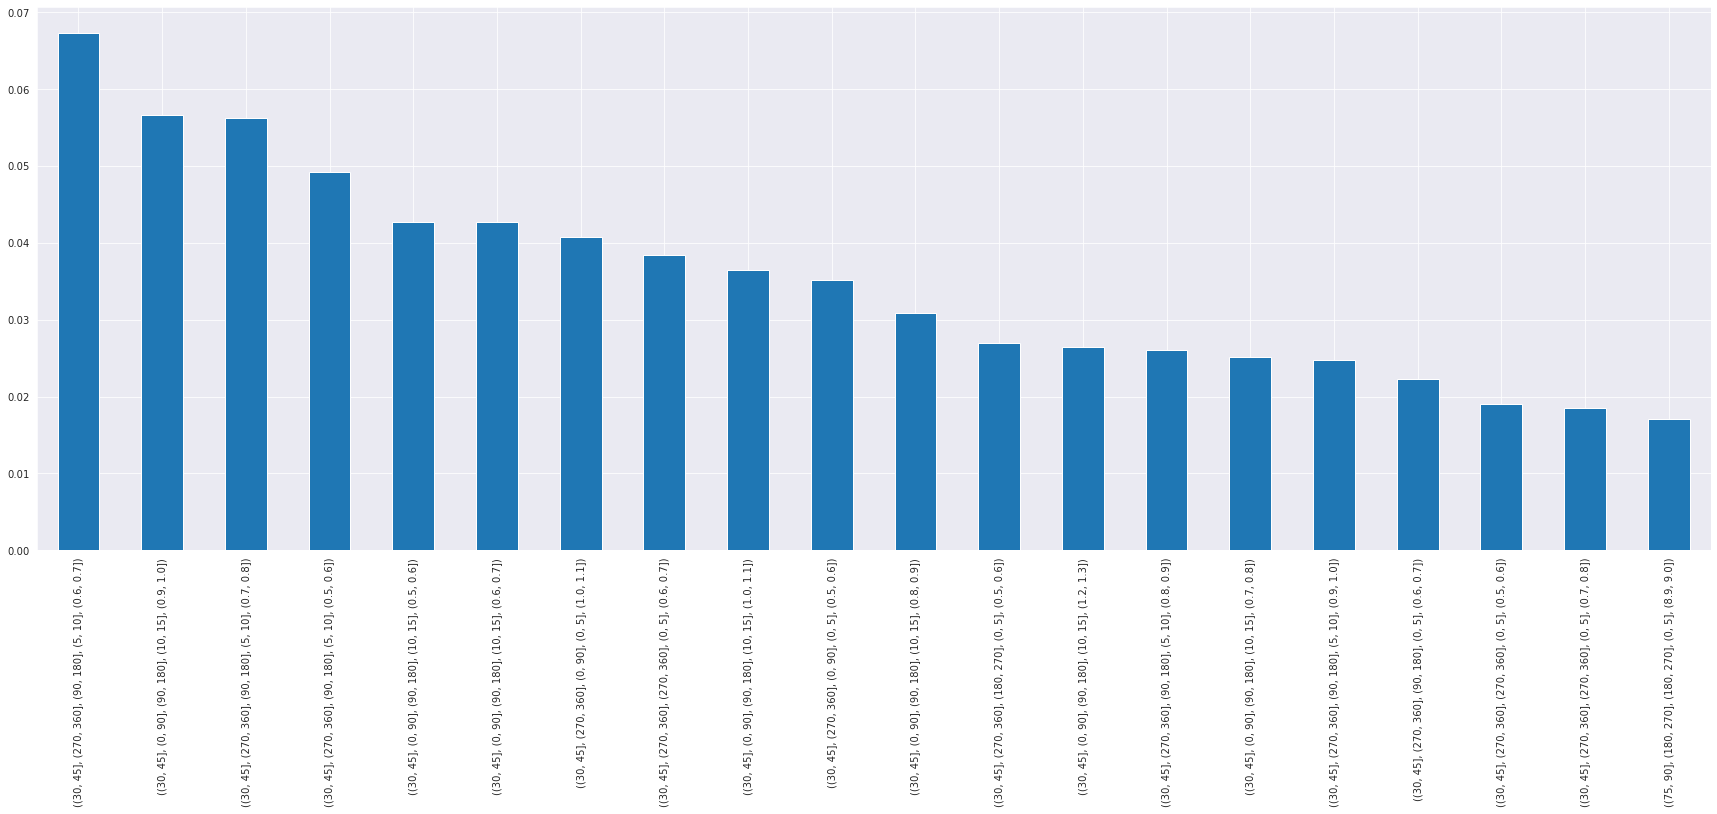

In [91]:
d = {}
group_var_independent_count = group_var_independent.count()
for index, value in group_var_filter.items():
    for i,v in group_var_independent_count.items():
        if i == index[:-1]:
            #print(f"Index : {index}, Value : {value/v}")
            d[index]=value/v

ser = pd.Series(data=d).nlargest(n=20)

ser.plot.bar()

<AxesSubplot:xlabel='MACS.ElevationAxis.position,MACS.AzimuthAxis.position,EMCS.WeatherStation.windDirection,EMCS.WeatherStation.meanWindSpeed,MACS.AzimuthAxis.followingError'>

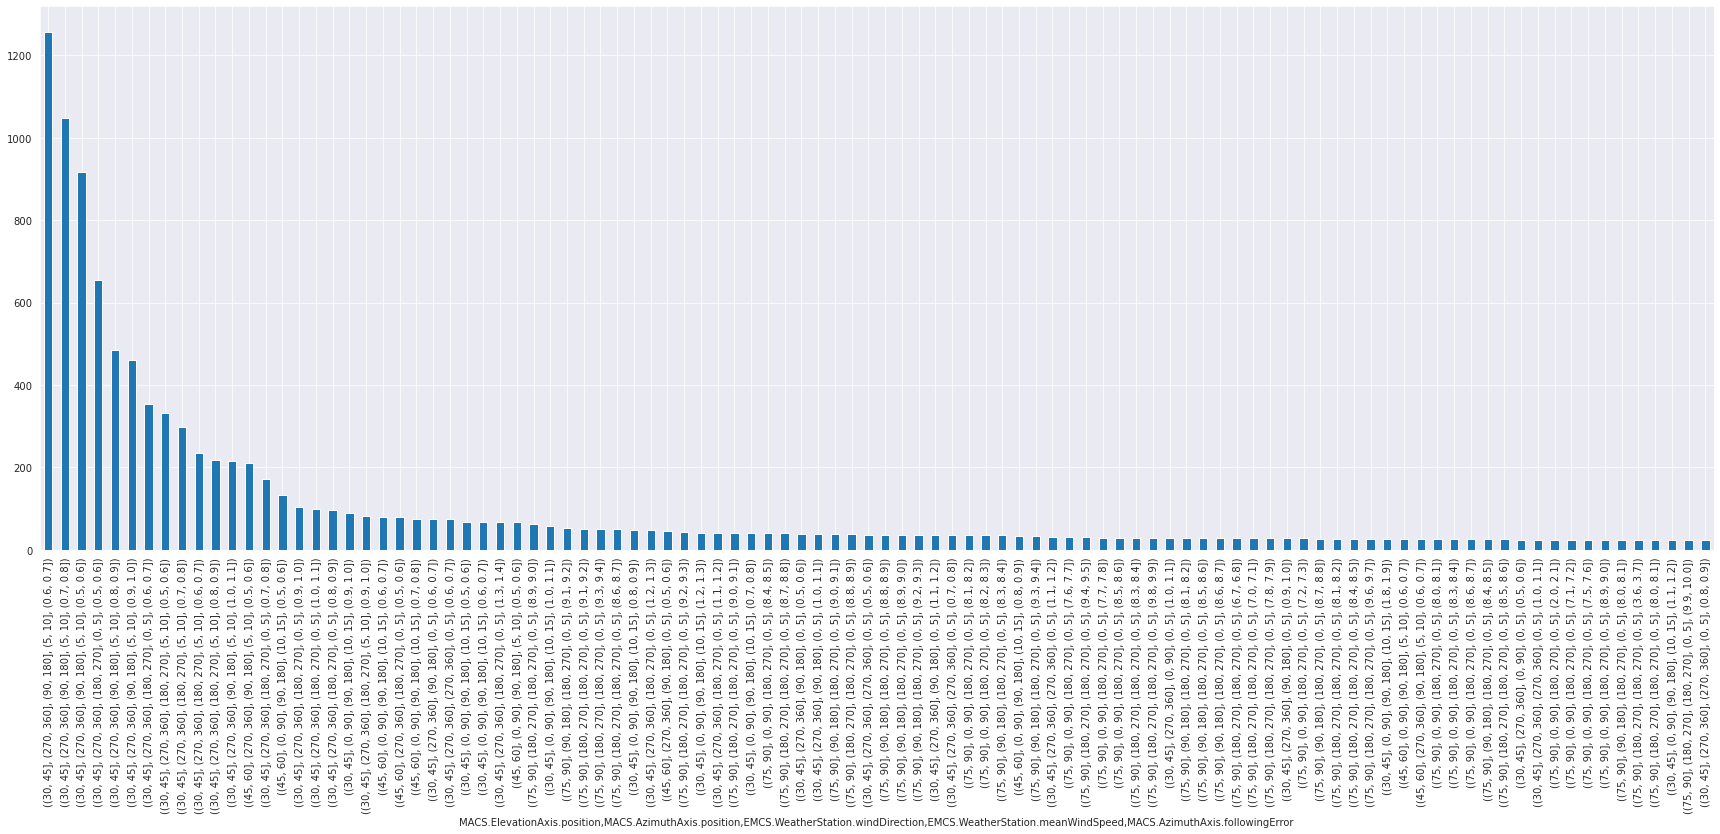

In [88]:
group_var = df_guiding.groupby (
    [
        pd.cut(x=df_guiding['MACS.ElevationAxis.position'], bins=np.arange(30,90+15,15)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.position'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.windDirection'], bins=np.arange(0,360+90,90)),
        pd.cut(x=df_guiding['EMCS.WeatherStation.meanWindSpeed'], bins=np.arange(0,15+5,5)),
        pd.cut(x=df_guiding['MACS.AzimuthAxis.followingError'].abs(), bins=np.arange(0.5,10+0.1,0.1))

    ]
)  ['MACS.AzimuthAxis.followingError']

group_var_filter = group_var.count().nlargest(n=100)
group_var_filter.plot.bar()

<AxesSubplot:>

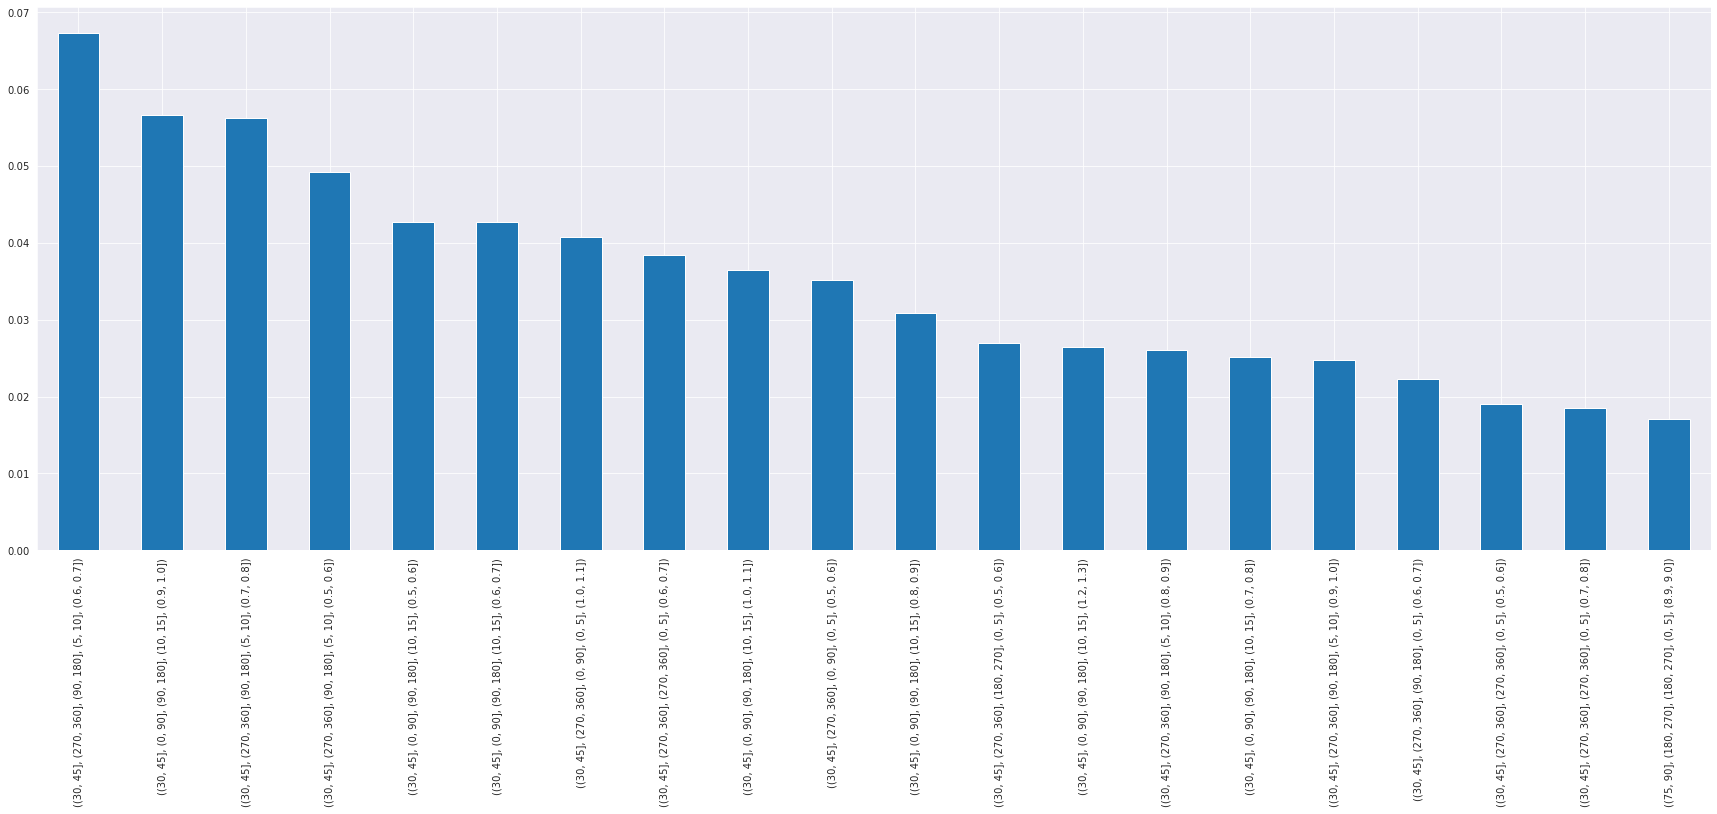

In [90]:
d = {}
group_var_independent_count = group_var_independent.count()
for index, value in group_var_filter.items():
    for i,v in group_var_independent_count.items():
        if i == index[:-1]:
            #print(f"Index : {index}, Value : {value/v}")
            d[index]=value/v

ser = pd.Series(data=d).nlargest(n=20)


ser.plot.bar()